In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
deliveries= pd.read_csv('../data/clean/deliveries.csv')
routes = pd.read_csv('../data/clean/routes.csv')

In [3]:
deliveries = deliveries.merge(routes, on='route_id', how='inner')

In [4]:
date_fields=[
    'pickup_dt',
    'max_pickup_dt',
    'pickup_arrival_dt',
    'pickup_effective_dt',
    'delivery_dt',
    'max_delivery_dt',
    'delivery_arrival_dt',
    'delivery_effective_dt'
]

for date_field in date_fields:
    deliveries[date_field]=pd.to_datetime(deliveries[date_field]).dt.tz_localize('UTC').dt.tz_convert('America/Fortaleza')

In [5]:
deliveries["pickup_delay"] = (deliveries["pickup_effective_dt"] - deliveries["max_pickup_dt"]).dt.total_seconds() / 3600
deliveries["delivery_delay"] = (deliveries["delivery_effective_dt"] - deliveries["max_delivery_dt"]).dt.total_seconds() / 3600

In [6]:
deliveries["is_delayed_delivery"] = deliveries["delivery_delay"] > 0
deliveries["is_delayed_pickup"] = deliveries["pickup_delay"] > 0

In [7]:
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

## 1.  ¿Cómo es la distribución de las entregas por los días de la semana?

In [8]:
deliveries['week_day_pickup'] = deliveries['pickup_arrival_dt'].dt.day_name()
deliveries['week_day_delivery'] = deliveries['delivery_arrival_dt'].dt.day_name()

In [9]:
pickup_per_day = deliveries.groupby('week_day_pickup')['id'].count().reset_index()
pickup_per_day.columns = ['week_day_pickup', 'pickups_per_day']
pickup_per_day.head()

,week_day_pickup,pickups_per_day
0,Friday,12952
1,Monday,20209
2,Saturday,7310
3,Sunday,2334
4,Thursday,13148


In [10]:
deliveries_per_day = deliveries.groupby('week_day_delivery')['id'].count().reset_index()
deliveries_per_day.columns = ['week_day_delivery', 'deliveries_per_day']
# sort by week_day_delivery
deliveries_per_day = deliveries_per_day.sort_values(by='deliveries_per_day', ascending=False)
deliveries_per_day.head()

,week_day_delivery,deliveries_per_day
1,Monday,19644
5,Tuesday,18400
6,Wednesday,16282
4,Thursday,13686
0,Friday,13052


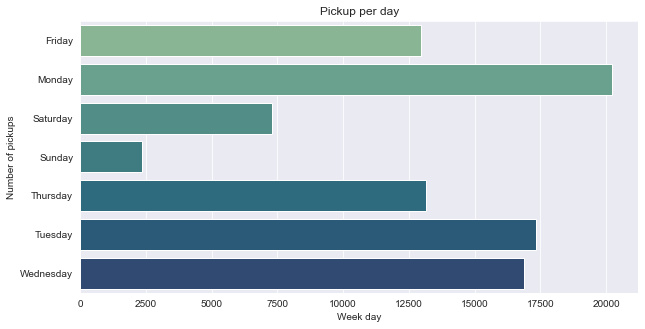

In [11]:
# barplot og week_day_pickup
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(y='week_day_pickup', x='pickups_per_day', data=pickup_per_day, ax=ax, palette='crest')
ax.set_title('Pickup per day')
ax.set_xlabel('Week day')
_ = ax.set_ylabel('Number of pickups')

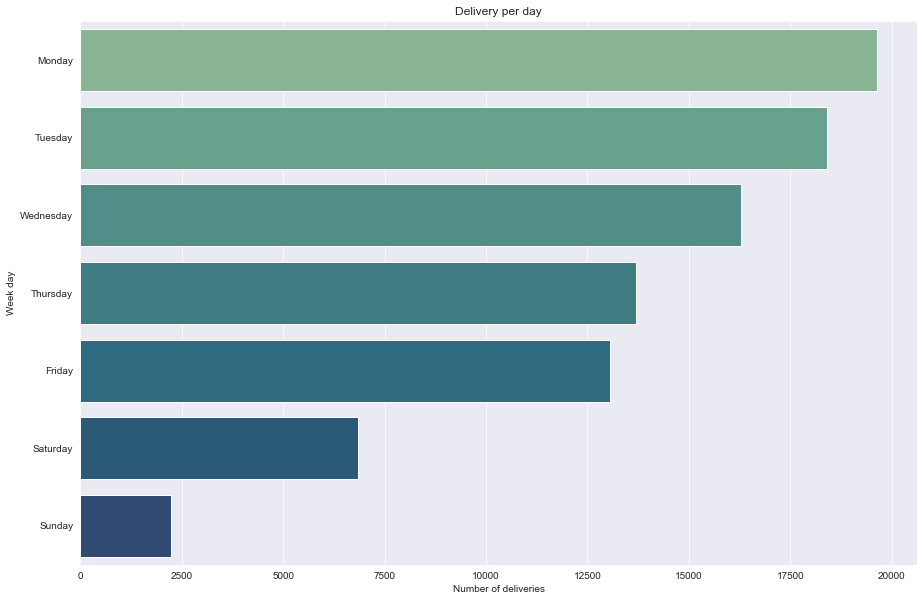

In [12]:
# bar plot of week_day_delivery
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='deliveries_per_day', y='week_day_delivery', data=deliveries_per_day, ax=ax,  palette='crest')
ax.set_title('Delivery per day')
ax.set_xlabel('Number of deliveries')
x = ax.set_ylabel('Week day')

## 2. ¿En qué momento del día existe mayor tráfico de recolecciones y entregas?

In [13]:
def generate_pivot_table_day(key,df):
    day_colum=f'day_{key}'
    df[day_colum]=df[key].dt.day_name()

    df_reindex=df.set_index(key)
    delivery_reindex=df_reindex.groupby([df_reindex.index.hour,day_colum]).count().reset_index()
    t_pivot= pd.pivot_table(delivery_reindex, index=[key], columns=day_colum,values="id", fill_value=0)
    t_pivot=t_pivot.reindex(days,axis=1)
    t_pivot.sort_index(level=0,ascending=False,inplace=True)
    return t_pivot

In [14]:
t_delivery_arrival_dt=generate_pivot_table_day('delivery_arrival_dt',deliveries)
t_pickup_effective_dt=generate_pivot_table_day('pickup_dt',deliveries)

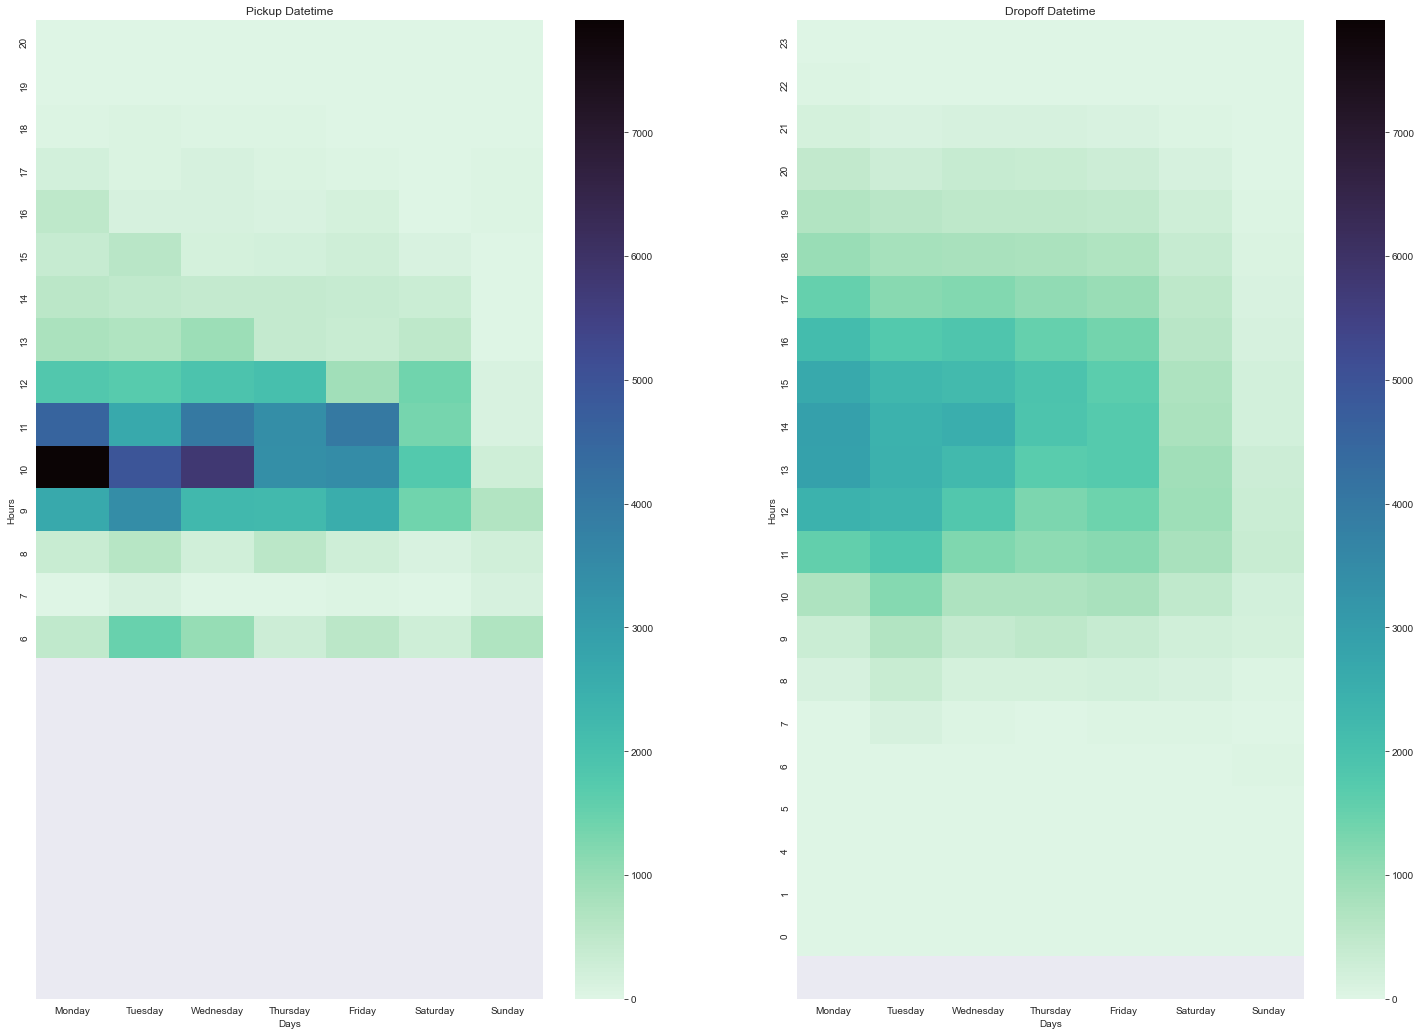

In [15]:
sns.set_style('darkgrid')
fig,axs= plt.subplots(1,2,figsize=(25,18))
mini=min(t_pickup_effective_dt.min().min(),t_delivery_arrival_dt.min().min())
maxi=max(t_pickup_effective_dt.max().max(),t_delivery_arrival_dt.max().max())
ax1=sns.heatmap(t_pickup_effective_dt,ax=axs[0],cmap=sns.color_palette("mako_r", as_cmap=True),vmin=mini, vmax=maxi)
ax2=sns.heatmap(t_delivery_arrival_dt,ax=axs[1],cmap=sns.color_palette("mako_r", as_cmap=True),vmin=mini, vmax=maxi)
ax1.set_ylim(23,0)
ax2.set_ylim(23,0)
ax1.set_ylabel('Hours')
ax2.set_ylabel('Hours')
ax1.set_xlabel('Days')
ax2.set_xlabel('Days')
ax1.set_title('Pickup Datetime')
_ = ax2.set_title('Dropoff Datetime')

## 3. ¿Qué día de la semana están más activos los shippers?

In [16]:
pickup_key = 'pickup_arrival_dt'
day_key=f'day_{pickup_key}'

In [17]:
deliveries[day_key]=deliveries[pickup_key].dt.day_name()
shipper_route_days=deliveries.groupby([day_key,'shipper_id']).agg({'route_id':lambda x: x.unique().size})

In [18]:
shipper_route_days

route_id
day_pickup_arrival_dt shipper_id          
Friday                238.0              4
                      984.0              2
                      14525.0            9
                      16235.0            5
                      17630.0            8
...                                    ...
Wednesday             393772.0           1
                      393890.0           1
                      395299.0           1
                      398511.0           1
                      400721.0           1

[1243 rows x 1 columns]

In [19]:
min_value = shipper_route_days.route_id.min()
max_value = shipper_route_days.route_id.max()

In [20]:
shipper_route_days.median(level=day_key)

C:\Users\COREI7~1\AppData\Local\Temp/ipykernel_9116/1599157803.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  shipper_route_days.median(level=day_key)


,route_id
day_pickup_arrival_dt,
Friday,2.0
Monday,2.0
Saturday,1.0
Sunday,1.0
Thursday,2.0
Tuesday,2.0
Wednesday,2.0


NameError: name 'sbn' is not defined

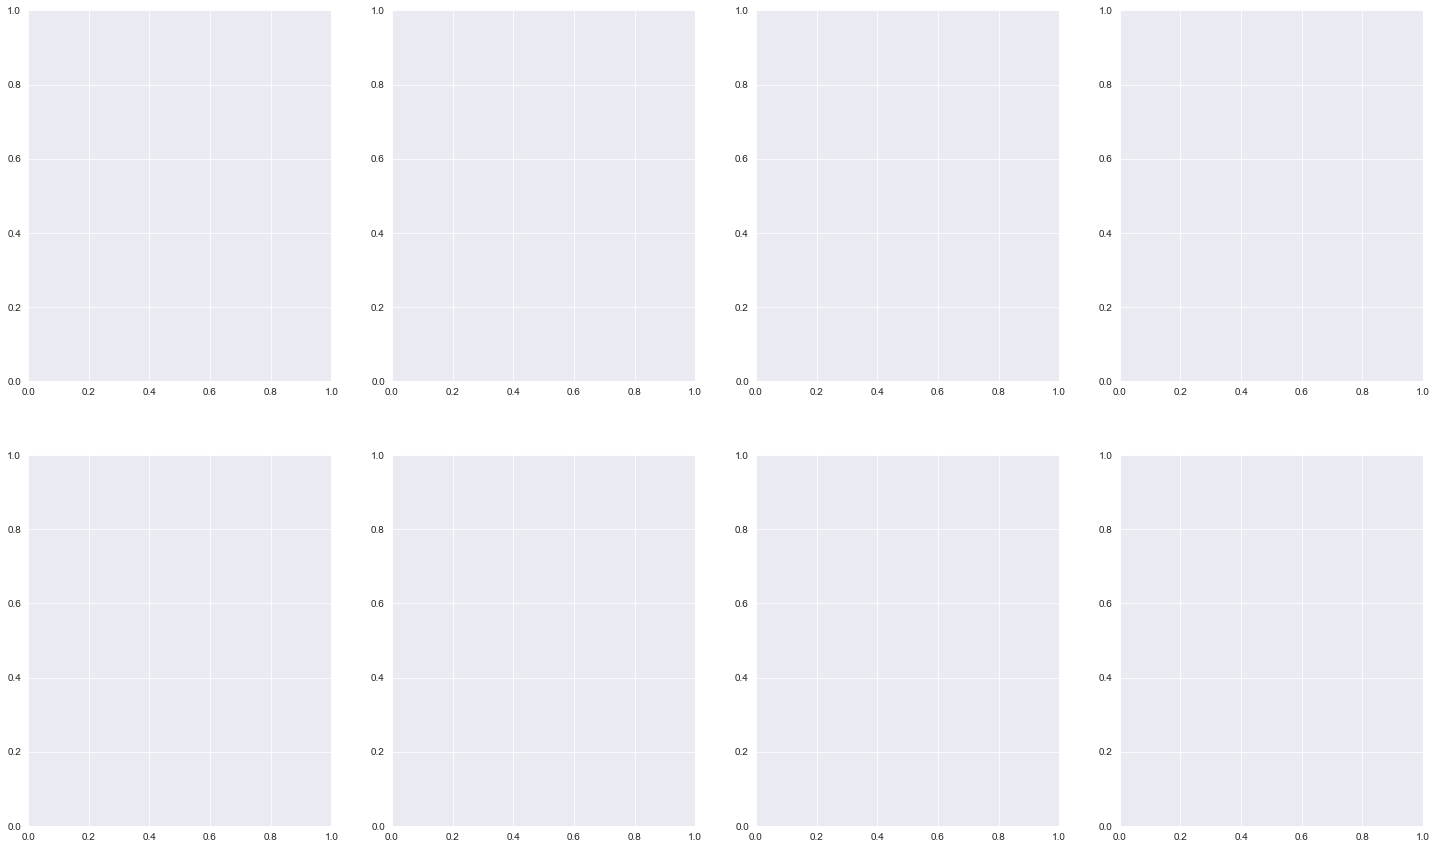

In [21]:
fig,axs= plt.subplots(2,4,figsize=(25,15))

lista=[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
for indice,i in enumerate(days):
    df_dia=shipper_route_days.xs(i)
    df_dia = df_dia.loc[(np.abs(stats.zscore(df_dia['route_id'])) < 3) & (np.abs(stats.zscore(df_dia['route_id'])) < 3)]
    fila,col=lista[indice]
    ax=sbn.boxplot(y=df_dia["route_id"],ax=axs[fila,col],palette='rainbow_r')
    ax.title.set_text(i)
    ax.set_ylabel('Count of routes')
    ax.set_ylim(min(min_value,0),max_value)

## 4. ¿Existe un patrón en la actividad diaria durante el mes?

In [ ]:
df2 = deliveries.loc[deliveries['pickup_arrival_dt'] <= '2022-05-31', ['id', 'pickup_arrival_dt', 'delivery_arrival_dt']]
df2_activity_pickup = df2.groupby([pd.Grouper(key='pickup_arrival_dt', freq='D')])['id'].count().reset_index()
df2_activity_delivery = df2.groupby([pd.Grouper(key='delivery_arrival_dt', freq='D')])['id'].count().reset_index()
df2_activity_pickup.columns = ['day', 'pickups_per_day']
df2_activity_delivery.columns = ['day', 'deliveries_per_day']
df_total_activity = pd.merge(df2_activity_pickup, df2_activity_delivery, on='day', how='inner')
df_total_activity['total_activity'] = df_total_activity['pickups_per_day'] + df_total_activity['deliveries_per_day']
## format day to number of calendar day
df_total_activity['day'] = df_total_activity['day'].dt.day

df_total_activity.head()

,day,pickups_per_day,deliveries_per_day,total_activity
0,1,115,95,210
1,2,4326,3816,8142
2,3,3619,3914,7533
3,4,4884,4285,9169
4,5,3847,4178,8025


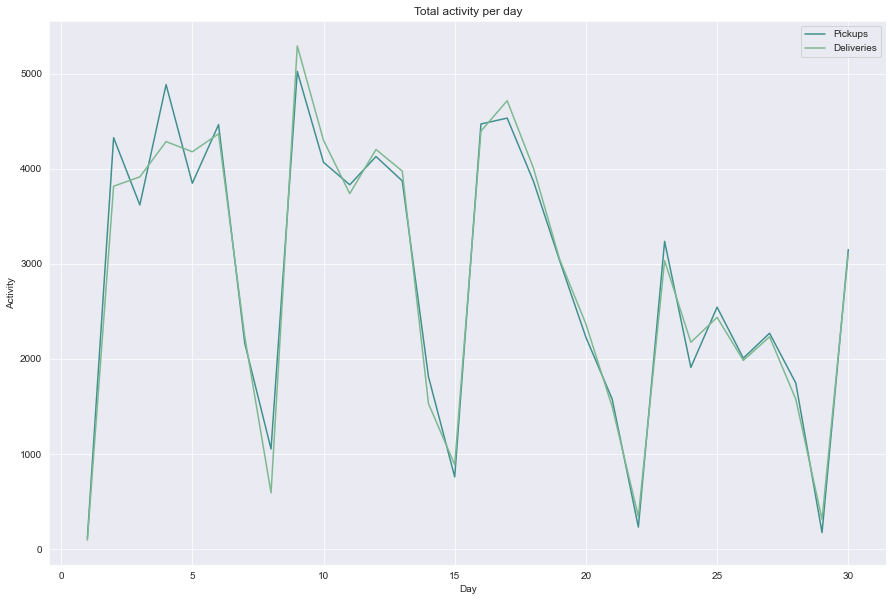

In [ ]:
## line plot total deliveries per day
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x='day', y='pickups_per_day', data=df_total_activity,  markers=True, dashes=False, ax=ax , color='#3f908e')
sns.lineplot(x='day', y='deliveries_per_day', data=df_total_activity,  markers=True, dashes=False, ax=ax , color='#7cb990')
ax.legend(['Pickups', 'Deliveries'])
max_delivery = df_total_activity['deliveries_per_day'].max()
max_pickup = df_total_activity['pickups_per_day'].max()
ax.set_title('Total activity per day')
ax.set_xlabel('Day')
_ = ax.set_ylabel('Activity')

## 5. ¿Se puede identificar qué días de la semana es más probable que las entregas se retrase?

In [ ]:
def delays_by_day_fn(dt_field, is_delayed_field, deliveries):
    delays_by_day = deliveries.groupby(deliveries[dt_field].dt.day_of_week).agg({is_delayed_field:np.sum,"id":"count"}).reset_index()
    delays_by_day["percentage"] = (delays_by_day[is_delayed_field] / delays_by_day["id"])*100
    delays_by_day.columns = ["day","delayed_count","total_count","percentage"]
    delays_by_day["day"] = delays_by_day["day"].map({0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
    return delays_by_day

In [ ]:
deliv_delays_by_day = delays_by_day_fn("delivery_effective_dt","is_delayed_delivery",deliveries)
pickup_delays_by_day = delays_by_day_fn("pickup_effective_dt","is_delayed_pickup",deliveries)
pickup_delays_by_day

,day,delayed_count,total_count,percentage
0,Monday,2883,20198,14.273690
1,Tuesday,3259,17348,18.786027
2,Wednesday,3331,16864,19.752135
3,Thursday,5232,13103,39.929787
4,Friday,2326,13007,17.882679
5,Saturday,881,7305,12.060233
6,Sunday,1107,2329,47.531129


In [ ]:
def graph_barplot(df, x_label, title):
    df.sort_values(by="percentage", inplace=True, ascending=False)
    ax, fig = plt.subplots(figsize=(10,7))
    sns.set_style("darkgrid")
    sns.barplot(data=df, x="percentage", y="day", palette="crest")
    plt.xlabel(x_label)
    _ = plt.title(title)

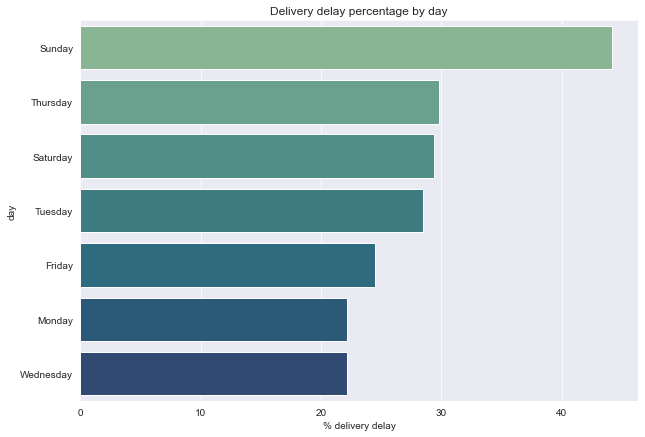

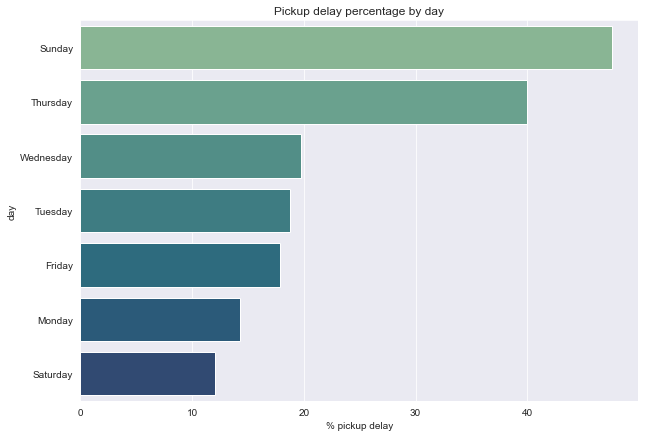

In [ ]:
graph_barplot(deliv_delays_by_day, "% delivery delay", "Delivery delay percentage by day")
graph_barplot(pickup_delays_by_day, "% pickup delay", "Pickup delay percentage by day")

## 6. ¿Existe una relación entre el costo por km recorrido y la cantidad de horas de retraso?

In [ ]:
cost_km_routes = deliveries.groupby(['route_id']).agg({'distance_route': 'sum', 'cost': 'sum'}).reset_index()

In [ ]:
(cost_km_routes["distance_route"] == 0).sum()

5

In [ ]:
# imputar distance_route
cost_km_routes.loc[cost_km_routes["distance_route"] == 0, "distance_route"] = cost_km_routes["distance_route"].mean()

In [ ]:
cost_km_routes["cost_km"] = cost_km_routes["cost"] / cost_km_routes["distance_route"]

In [ ]:
cost_km_routes

,route_id,distance_route,cost,cost_km
0,r-shiinc-1246958,25.3,78.7290,3.111818
1,r-shiinc-1246971,56.0,154.4105,2.757330
2,r-shiinc-1247025,25.7,103.3735,4.022315
3,r-shiinc-1247028,19.4,117.0240,6.032165
4,r-shiinc-1247029,21.0,84.9620,4.045810
...,...,...,...,...
2930,r-shiinc-1318979,0.7,6.4100,9.157143
2931,r-shiinc-1318988,0.8,2.9900,3.737500
2932,r-shiinc-1318998,0.1,2.9900,29.900000
2933,r-shiinc-1319014,2.1,2.9900,1.423810


In [ ]:
deliveries_cost_km = deliveries.merge(cost_km_routes[["route_id", "cost_km"]], on='route_id', how='inner')

In [ ]:
deliveries_cost_km

,id,route_id,state,_status,items,total_size,pickupLat,pickupLng,deliveryLat,deliveryLng,...,pickup_delay,delivery_delay,is_delayed_delivery,is_delayed_pickup,week_day_pickup,week_day_delivery,day_delivery_arrival_dt,day_pickup_dt,day_pickup_arrival_dt,cost_km
0,t-amabrt-1743660,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004818881','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4522,-44.2543,...,-0.375833,0.172778,True,False,Monday,Monday,Monday,Monday,Monday,2.524978
1,t-amabrt-1743667,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004810225','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4372,-44.2292,...,-0.375833,-7.935556,False,False,Monday,Monday,Monday,Monday,Monday,2.524978
2,t-amabrt-1743673,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004807779','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4381,-44.2479,...,-0.375833,-5.369444,False,False,Monday,Monday,Monday,Monday,Monday,2.524978
3,t-amabrt-1743742,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004819106','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4258,-44.2426,...,-0.375833,-13.520556,False,False,Monday,Monday,Monday,Monday,Monday,2.524978
4,t-amabrt-1743835,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004811623','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4434,-44.2558,...,-0.375833,-3.652500,False,False,Monday,Monday,Monday,Monday,Monday,2.524978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90149,t-petz-3241873,r-shiinc-1272990,7,completed,"[{'id':'107645|1','name':'NFs: 000109769 ...",3,-19.9627,-43.9570,-19.9781,-44.0462,...,0.300278,-0.853889,False,True,Monday,Monday,Monday,Monday,Monday,2.602580
90150,t-petz-3241874,r-shiinc-1272990,7,completed,"[{'id':'107675|1','name':'NFs: 000110208 ...",4,-19.9627,-43.9570,-19.9770,-43.9439,...,0.300278,0.146389,True,True,Monday,Monday,Monday,Monday,Monday,2.602580
90151,t-petz-3241899,r-shiinc-1272990,7,completed,"[{'id':'106705|1','name':'NFs: 000109807 ...",3,-19.9627,-43.9570,-19.9721,-43.9658,...,0.300278,0.015278,True,True,Monday,Monday,Monday,Monday,Monday,2.602580
90152,t-petz-3241951,r-shiinc-1272990,7,completed,"[{'id':'107367|1','name':'NFs: 000110203 ...",4,-19.9627,-43.9570,-19.9373,-43.9760,...,0.300278,-0.926389,False,True,Monday,Monday,Monday,Monday,Monday,2.602580


In [ ]:
df_rel = deliveries_cost_km[['id', 'delivery_delay', 'cost_km']]
df_rel = df_rel.loc[(np.abs(stats.zscore(df_rel['delivery_delay'])) < 3) & (np.abs(stats.zscore(df_rel['cost_km'])) < 3)]

c:\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


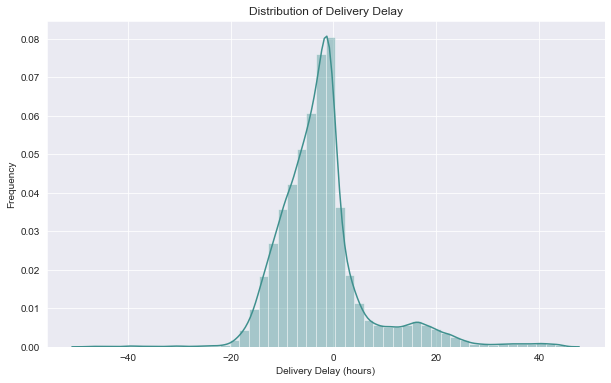

In [ ]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(figsize=(10, 6))
# Distribucion de los tiempos de espera de delivery
sns.distplot(df_rel["delivery_delay"], ax=axs, color='#3f908e')
axs.set_title('Distribution of Delivery Delay')
axs.set_xlabel('Delivery Delay (hours)')
_ = axs.set_ylabel('Frequency')

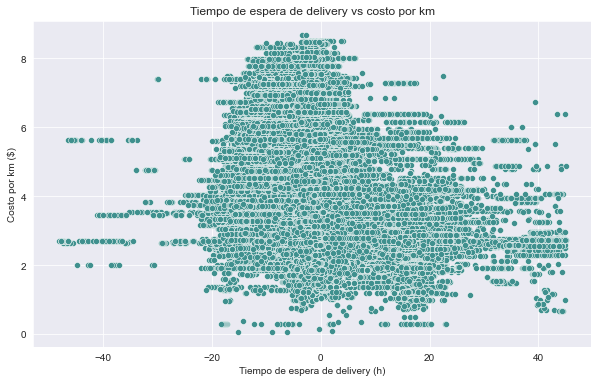

In [ ]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(figsize=(10, 6))
sns.scatterplot(x="delivery_delay", y="cost_km", data=df_rel, ax=axs, color='#3f908e')
axs.set_xlabel('Tiempo de espera de delivery (h)')
axs.set_ylabel('Costo por km ($)')
_ = axs.set_title('Tiempo de espera de delivery vs costo por km')

In [ ]:
df_rel["delivery_delay"].corr(df_rel["cost_km"])

-0.2046927069739054

## 7. ¿Cómo influye el retraso de la recolección en el tiempo de entrega de los deliveries?

In [ ]:
df_rel = deliveries[['id', 'pickup_delay', 'delivery_delay']]
df_rel = df_rel.loc[(np.abs(stats.zscore(df_rel['pickup_delay'])) < 3) & (np.abs(stats.zscore(df_rel['delivery_delay'])) < 3)]

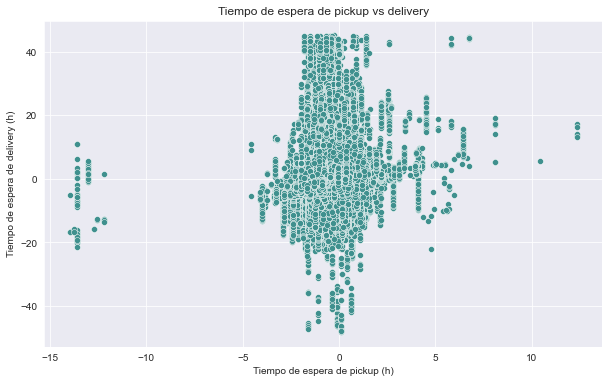

In [ ]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(figsize=(10, 6))
sns.scatterplot(x="pickup_delay", y="delivery_delay", data=df_rel, ax=axs, color='#3f908e')
axs.set_xlabel('Tiempo de espera de pickup (h)')
axs.set_ylabel('Tiempo de espera de delivery (h)')
_ = axs.set_title('Tiempo de espera de pickup vs delivery')

In [ ]:
df_rel["pickup_delay"].corr(df_rel["delivery_delay"])

0.1234701816466346

## 8 ¿Se puede identificar qué tipo de vehículo es más probable que se retirase al realizar las entregas?

In [ ]:
df3 = deliveries.loc[:, ['id','route_id', 'delivery_effective_dt', 'max_delivery_dt']]
df3['delivery_effective_dt'] = pd.to_datetime(df3['delivery_effective_dt'])
df3['max_delivery_dt'] = pd.to_datetime(df3['max_delivery_dt'])
df3['delay'] = (df3['delivery_effective_dt'] - df3['max_delivery_dt']).dt.total_seconds() / 3600
df3['has_delay'] = df3['delay'] > 0
df3.head()

,id,route_id,delivery_effective_dt,max_delivery_dt,delay,has_delay
0,t-amabrt-1743660,r-shiinc-1248026,2022-05-02 12:52:13-03:00,2022-05-02 12:41:51-03:00,0.172778,True
1,t-amabrt-1743667,r-shiinc-1248026,2022-05-02 14:30:26-03:00,2022-05-02 22:26:34-03:00,-7.935556,False
2,t-amabrt-1743673,r-shiinc-1248026,2022-05-02 13:54:58-03:00,2022-05-02 19:17:08-03:00,-5.369444,False
3,t-amabrt-1743742,r-shiinc-1248026,2022-05-02 15:43:58-03:00,2022-05-03 05:15:12-03:00,-13.520556,False
4,t-amabrt-1743835,r-shiinc-1248026,2022-05-02 13:33:04-03:00,2022-05-02 17:12:13-03:00,-3.652500,False


In [ ]:
df_routes = pd.read_csv('../data/clean/routes.csv')
df_final = pd.merge(df3, df_routes, on='route_id', how='inner')
df_per_capacity = df_final.groupby('route_capacity').agg({'id': 'count', 'has_delay': 'sum'}).reset_index()
df_per_capacity.columns = ['route_capacity', 'total_deliveries', 'total_deliveries_with_delay']
df_per_capacity['percentage'] = ((df_per_capacity['total_deliveries_with_delay'] / df_per_capacity['total_deliveries'])*100).round(2)
#sort by percentage
df_per_capacity = df_per_capacity.sort_values(by='percentage', ascending=False)

df_per_capacity

,route_capacity,total_deliveries,total_deliveries_with_delay,percentage
0,1,10,9,90.00
1,2,793,365,46.03
3,4,1664,628,37.74
4,5,178,52,29.21
2,3,87509,22408,25.61


In [ ]:
def set_vehicle_type(x):
    if x == 1:
        return 'Bicycle'
    elif x == 2:
        return 'Motorcycle'
    elif x == 3:
        return 'Car'
    elif x == 4:
        return 'Van'
    else:
        return 'Truck'

df_per_capacity['vehicle_type'] = df_per_capacity['route_capacity'].apply(set_vehicle_type)
df_per_capacity

,route_capacity,total_deliveries,total_deliveries_with_delay,percentage,vehicle_type
0,1,10,9,90.00,Bicycle
1,2,793,365,46.03,Motorcycle
3,4,1664,628,37.74,Van
4,5,178,52,29.21,Truck
2,3,87509,22408,25.61,Car


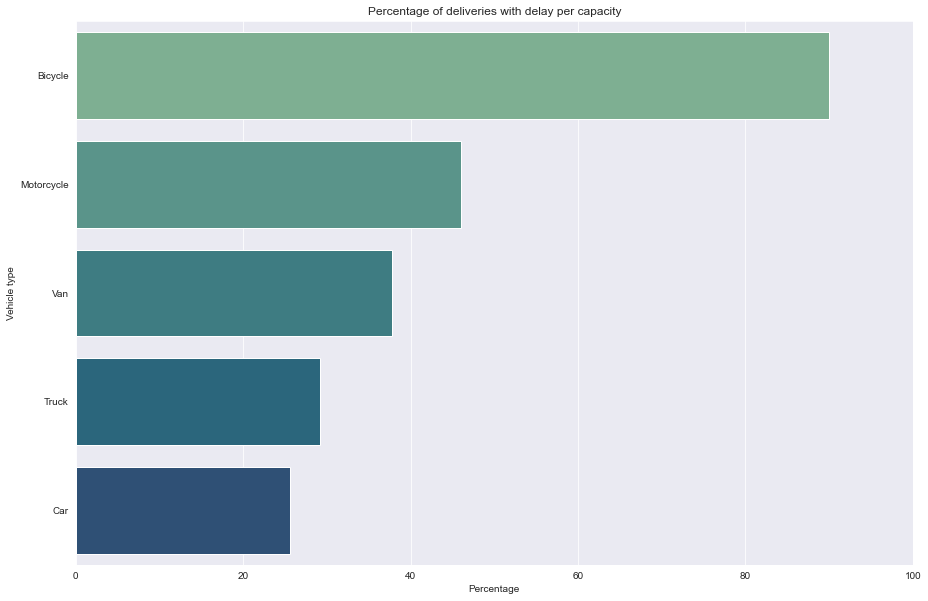

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='percentage', y='vehicle_type', data=df_per_capacity, ax=ax, palette='crest')
ax.set_title('Percentage of deliveries with delay per capacity')
ax.set_xlabel('Percentage')
ax.set_ylabel('Vehicle type')
## limit on x
_ = ax.set_xlim(0, 100)

## 9. ¿Se puede identificar si existe una diferencia entre las distancias de las rutas asignadas a cada tipo de vehículo?

In [ ]:
deliveries["distance_route"]

0         0.3
1         0.6
2         0.7
3         0.6
4         0.3
         ... 
90149     9.5
90150     0.7
90151     4.4
90152    11.0
90153     1.6
Name: distance_route, Length: 90154, dtype: float64

In [ ]:
distance_routes_vehicles = deliveries.groupby(['route_id', 'route_capacity']).agg({'distance_route': 'sum'}).reset_index()

In [ ]:
distance_routes_vehicles = distance_routes_vehicles.loc[distance_routes_vehicles["distance_route"] > 0]

In [ ]:
IQR = distance_routes_vehicles['distance_route'].quantile(0.75) - distance_routes_vehicles['distance_route'].quantile(0.25)
distance_routes_vehicles = distance_routes_vehicles.loc[np.abs(distance_routes_vehicles['distance_route'] - distance_routes_vehicles['distance_route'].mean()) < (1.5 * IQR)]

In [ ]:
distance_routes_vehicles.head()

,route_id,route_capacity,distance_route
0,r-shiinc-1246958,3,25.3
1,r-shiinc-1246971,3,56.0
2,r-shiinc-1247025,3,25.7
3,r-shiinc-1247028,3,19.4
4,r-shiinc-1247029,3,21.0


In [ ]:
# Se descartan las bicicletas porque solo existen 2 rutas
distance_routes_vehicles["route_capacity"].value_counts()

3    2530
2     113
4      64
5      20
1       2
Name: route_capacity, dtype: int64

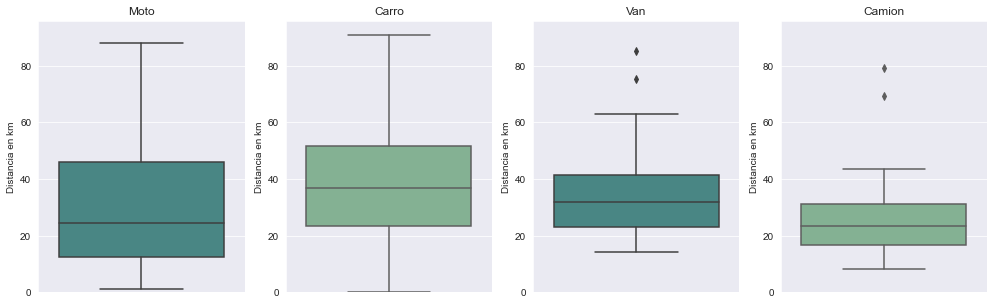

In [ ]:
min_value = min(distance_routes_vehicles['distance_route'].min(), 0)
max_value = distance_routes_vehicles['distance_route'].max() + 5
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 4, figsize=(17, 5))
data_moto = distance_routes_vehicles.loc[distance_routes_vehicles['route_capacity'] == 2]
data_car = distance_routes_vehicles.loc[distance_routes_vehicles['route_capacity'] == 3]
data_van = distance_routes_vehicles.loc[distance_routes_vehicles['route_capacity'] == 4]
data_truck = distance_routes_vehicles.loc[distance_routes_vehicles['route_capacity'] == 5]
sns.boxplot(y=data_moto["distance_route"], ax=axs[0], color='#3f908e')
sns.boxplot(y=data_car["distance_route"], ax=axs[1], color='#7cb990')
sns.boxplot(y=data_van["distance_route"], ax=axs[2], color='#3f908e')
sns.boxplot(y=data_truck["distance_route"], ax=axs[3], color='#7cb990')
axs[0].set_title('Moto')
axs[1].set_title('Carro')
axs[2].set_title('Van')
axs[3].set_title('Camion')
for ax in axs:
  ax.set_ylabel('Distancia en km')
  ax.set_ylim(min_value, max_value)

## 10. ¿El shipper expertise influye en la probabilidad de que una entrega se retrase?

In [ ]:
shippers = deliveries.groupby("shipper_id").agg({"route_id":"nunique"}).reset_index()
shippers.columns= ["shipper_id", "expertise"]
shippers

,shipper_id,expertise
0,238.0,21
1,984.0,33
2,3134.0,2
3,6995.0,1
4,11277.0,1
...,...,...
397,402581.0,1
398,402635.0,2
399,402949.0,2
400,403140.0,1


In [ ]:
df_retr_ship = deliveries.groupby(["shipper_id"]).agg({"is_delayed_delivery":np.sum, "id":"count"}).reset_index()
df_retr_ship["percentage"] = (df_retr_ship["is_delayed_delivery"] / df_retr_ship["id"])*100
df_retr_ship.head()

,shipper_id,is_delayed_delivery,id,percentage
0,238.0,29,451,6.430155
1,984.0,102,265,38.490566
2,3134.0,0,38,0.000000
3,6995.0,15,35,42.857143
4,11277.0,0,43,0.000000


In [ ]:
dfm_shippers = shippers.merge(df_retr_ship, on="shipper_id")
dfm_shippers.head()

,shipper_id,expertise,is_delayed_delivery,id,percentage
0,238.0,21,29,451,6.430155
1,984.0,33,102,265,38.490566
2,3134.0,2,0,38,0.000000
3,6995.0,1,15,35,42.857143
4,11277.0,1,0,43,0.000000


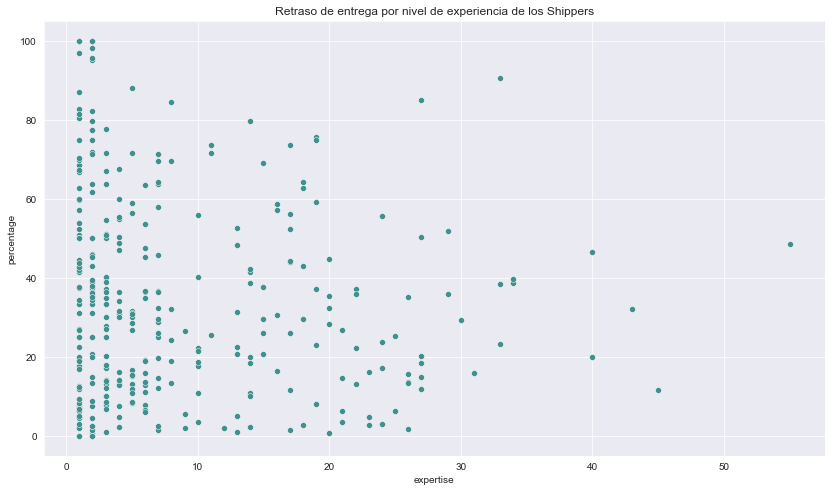

In [ ]:
sns.set_style("darkgrid")
ax, fig = plt.subplots(figsize=(14,8))
sns.scatterplot(x="expertise", y="percentage", data=dfm_shippers, color="#3f908e")
_ = plt.title("Retraso de entrega por nivel de experiencia de los Shippers")

In [ ]:
dfm_shippers["expertise"].corr(dfm_shippers["percentage"])

-0.02030587549269549